## «Модель прогнозирования стоимости жилья для агентства недвижимости»

### 1. Знакомство с данными.

In [168]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
import re
import optuna
import xgboost as xgb
from catboost import CatBoostRegressor
from statsmodels.graphics.gofplots import qqplot

In [169]:
# загружаем занные
data = pd.read_csv('data/data_real_property.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Описание данных:

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

➔ 'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);

➔ 'target' — цена объекта недвижимости (целевой признак).

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [171]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


В представленном датасете данные о  блее чем 300 000 объектов недвижимости и 18 их характеристик, все признаки имеют тип данных object. 

### 2. Очистка данных - обработка пропусков и дубликатов.

Признаки MlsId и mls-id являются идентификаторами, которые никак не влияют на цену недвижимости, удалим их.

In [172]:
data = data.drop(['MlsId', 'mls-id'], axis = 1)

Посмотрим на наличие пропусков в данных.

In [173]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print(cols_with_null)

private pool    98.891525
PrivatePool     89.312672
fireplace       72.662221
stories         39.958111
baths           28.192532
beds            24.200856
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64


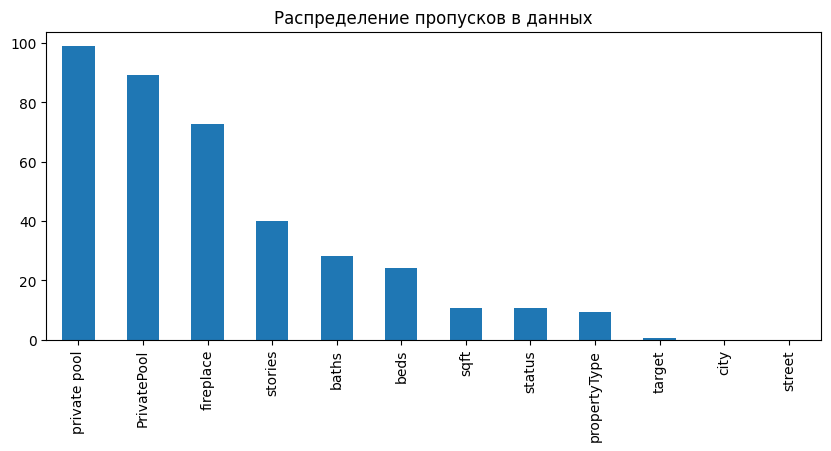

In [174]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

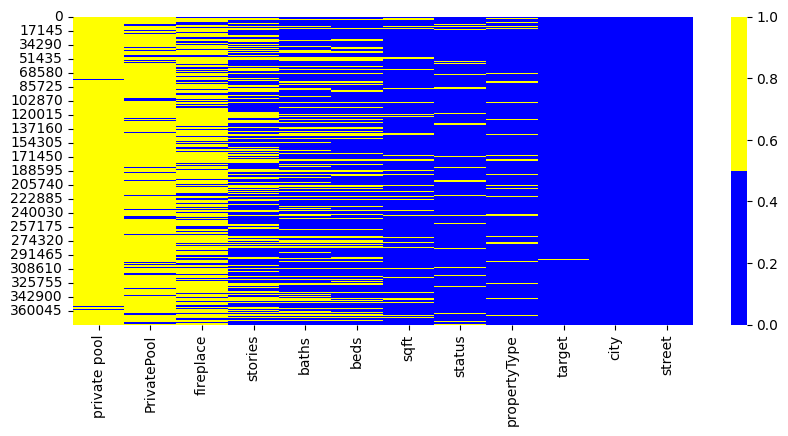

In [175]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

Очевидно, что три признака - private pool, PrivatePool, fireplace - имеют очень большое количество пропусков (более 70%). Кроме того, признаки private pool и PrivatePool несут одинаковую информацию о наличии бассейна, но даже объединив эти данные, доля пропусков все равно будет велика и их замена может исказить данные. Поэтмоу, несмотря на то, что наличие бассейна или камина могут оказывать влияние на стоимость недвижимости, эти данные придется удалить, так как восстановить их не представляется возможным.

In [176]:
# удалим все столбцы с пропусками более 40%
data = data.dropna(thresh=data.shape[0]*0.6, axis=1)

In [177]:
# найдем и удалим дубликаты
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')
sber_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Число найденных дубликатов: 141
Результирующее число записей: 377044


Проверим данные на неинформативные признаки, которые не играют роли при моделировании и лишь засоряют таблицу, увеличивая объем данных. Найдем признаки, в которых:
- 95% строк содержат одинаковые значения
- 95% строк содержат уникальные значения 

In [178]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
    else:
        print(f'{col} не является неинформативным признаком')

status не является неинформативным признаком
propertyType не является неинформативным признаком
street не является неинформативным признаком
baths не является неинформативным признаком
homeFacts не является неинформативным признаком
city не является неинформативным признаком
schools не является неинформативным признаком
sqft не является неинформативным признаком
zipcode не является неинформативным признаком
beds не является неинформативным признаком
state не является неинформативным признаком
stories не является неинформативным признаком
target не является неинформативным признаком


### 3. Преобразование данных и EDA.

Исследуем и преобразуем каждый признак.

Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении стимости недвижимости.

#### 3.1 Целевой признак - target.

In [179]:
# выведем статистику
data['target'].describe()

count       374704
unique       43939
top       $225,000
freq          1462
Name: target, dtype: object

In [180]:
# посмотрим на распределение
data['target'].value_counts().nlargest(15)

target
$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
$325,000    1244
$249,900    1241
$399,000    1239
$199,900    1199
$299,000    1176
$375,000    1163
$450,000    1141
$499,000    1099
$175,000    1096
$425,000    1075
Name: count, dtype: int64

Признак имеет большое количество уникальных значение, что неудивительно, так как цена всегда индивидуальна для каждого объекта. 

- Проверим признак на пропуски и удалим их, так как это целевой признак, а значит строк с пропусками в нем быть не должно. 
- Проверим признак на специфические данные (возможно есть данные, не отвечающие сути признака)
- Переведем признак в тип данных float.
- Проверим и избавимся, если нужно от выбросов.

In [181]:
data['target'].isnull().mean()*100

0.6577674085660883

In [182]:
data = data.dropna(subset=['target'])

In [184]:
data[data.target.str.contains('/mo',regex=True)]

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,target
547,for rent,single-family home,4323 N Central Park Ave,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",Chicago,"[{'rating': ['1/10', '4/10', '2/10', 'None/10'...","3,300 sqft",60618,4 Beds,IL,NaN,"$5,500/mo"
609,for rent,multi-family,220 Boylston St #1412,2 Baths,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,673 sqft",2116,2 Beds,MA,NaN,"$10,500/mo"
2075,for rent,single-family home,2830 NE 56th Ct,4 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",Fort Lauderdale,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...","2,400 sqft",33308,4 Beds,FL,NaN,"$6,390/mo"
3025,for rent,multi-family,411 Kline Aly,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",Clarksville,"[{'rating': ['8/10', '9/10', '7/10'], 'data': ...","1,280 sqft",37040,2 Beds,TN,NaN,"$1,200/mo"
3645,for rent,multi-family,240 E Illinois St #2011,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",Chicago,"[{'rating': ['4/10', '7/10'], 'data': {'Distan...","1,473 sqft",60611,2 Beds,IL,NaN,"$3,600/mo"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371791,for rent,multi-family,9436 Turrentine Dr,1.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",El Paso,"[{'rating': ['4/10', '8/10', '6/10'], 'data': ...","1,050 sqft",79925,2 Beds,TX,NaN,$890/mo
372459,for rent,townhouse,34 Jonquil Pl,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",The Woodlands,"[{'rating': ['5/10', '8/10', '7/10', '8/10'], ...","2,601 sqft",77375,3 Beds,TX,NaN,"$2,500/mo"
374288,for rent,single-family home,8864 Devonshire Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Fort Worth,"[{'rating': ['6/10', '5/10', '5/10'], 'data': ...","2,000 sqft",76131,4 Beds,TX,NaN,"$2,000/mo"
375550,for rent,townhouse,2217 W Seybert St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",Philadelphia,"[{'rating': ['1/10', '3/10'], 'data': {'Distan...",720 sqft,19121,2 Beds,PA,NaN,"$1,500/mo"


В данных есть объекты, предназначенные для аренды, они имеют стоимость за месяц. Такие данных нужно удалить, чтобы не было путаницы между продажей и арендой.

In [185]:
data = data.drop(data[data['status'] == 'for rent'].index)

In [187]:
# удалим ненужные символы и переведем в тип данных float
data['target'] = data['target'].apply(lambda x: str(x).replace('$', '').replace(',', '').replace(' ', '').replace('+', '')).astype(float)

Text(0.5, 1.0, 'Целевой признак до удаления выбросов')

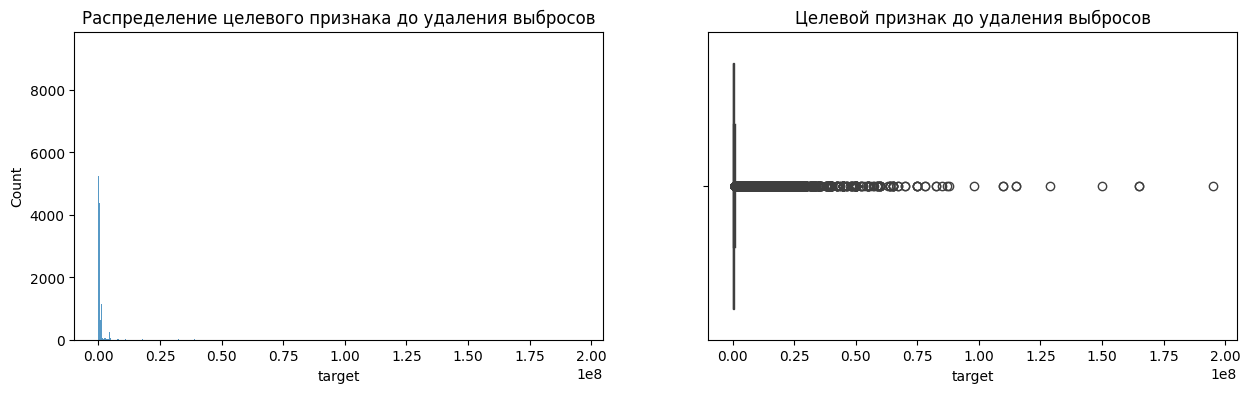

In [188]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'target', ax = axes[0]);
histplot.set_title('Распределение целевого признака до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'target', ax = axes[1])
boxplot.set_title('Целевой признак до удаления выбросов')

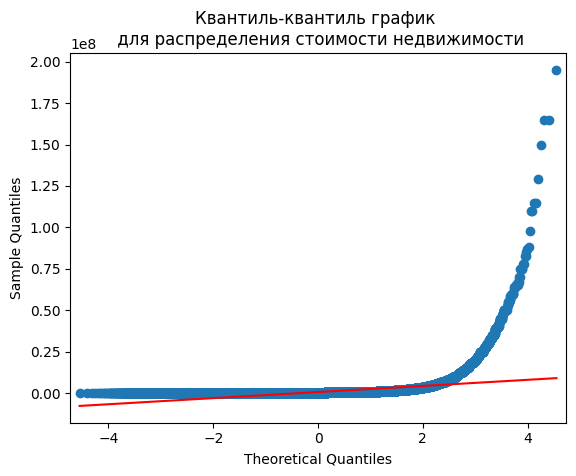

In [189]:
qqplot(data.target, line='s')
plt.title('Квантиль-квантиль график \n для распределения стоимости недвижимости')
plt.show()

Визуально распределение целевого признака не выглядит нормально. Проверим эту гипотезу с помощью статистического теста Д’Агостино (так как данных более 5000). 

H0 = 'Данные распределены нормально'

H1 = 'Данные не распределены нормально (мы отклоняем H0)'

Значение альфа - 0.5

In [190]:
alpha=0.5
_,p = stats.normaltest(data['target'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [191]:
def outliers_z_score(data, feature, log_scale=False):
    """Функция для определения выбросов в данных по методу z-отклонений и их удалению

    Args:
        data (DataFrame): таблица с данными
        feature: признак
        log_scale: параметр, отвечающий за логарифмирование (по умолчанию False)

    Returns:
        outliers: найденные выбросы
        cleaned: очищенная от выбросов таблица
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [192]:
outliers, cleaned = outliers_z_score(data, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 6112
Результирующее число записей: 368194


### 4. Решение задачи регрессии.

In [ ]:
sns.pairplot(data)

#### 4.1 Линейная регрессия.

#### 4.2 Дерево решений.

#### 4.3 Случайный лес

#### 4.3 Градиентыный бустинг

#### 4.3 Cat бустинг